In [1]:
%matplotlib inline

from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pandas options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)
# pd.options.display.float_format = '{:,.6f}'.format

#Set seaborn plot theme
sns.set_style('darkgrid')

# ACS Tables

In [33]:
query = """
SELECT table_id, row_count FROM `fccdsicapstone-218522.broadband.__TABLES__`
"""
tables = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

mask = (tables.table_id.str.contains('acs') &
        ~tables.table_id.str.contains('group') &
        ~tables.table_id.str.contains('level') &
        tables.row_count.between(190000, 220000))
tables[mask].sort_values('row_count', ascending=False)

,table_id,row_count
47,acs_with_geo_2014,216330
48,fcc_acs_with_geo_2014,216330
38,acs_with_geo_2015,216321
39,acs_with_geo_2016,216321
40,fcc_acs_with_geo_2015,216321
41,fcc_acs_with_geo_2016,216321
56,acs_education,212249
57,acs_school_enrollment,212249
55,acs_hispanic,212247
88,acs_employment,207265


# census_block, left join fcc and acs attributes

In [67]:
query = """
WITH block_level AS (
  SELECT 
    SUBSTR(block.block_code, 0, 12) AS block_group
    , block.total_length 
    , block.land_area
    , block.elevation_mean
    , block.elevation_range
    , CASE WHEN fcc.block_code IS NULL THEN 0 ELSE 1 END AS int_avail
    , fcc_demography.population_2016
  FROM broadband.census_block block
  LEFT JOIN (SELECT DISTINCT block_code FROM broadband.fcc WHERE file_date = 201706) fcc
    ON block.block_code = fcc.block_code
  LEFT JOIN broadband.fcc_demography
    ON block.block_code = fcc_demography.block_code
  WHERE fcc_demography.housing_unit_2016 > 0
),
block_group_level AS ( 
  SELECT 
    block_group
    , AVG(int_avail) AS int_avail_per
    , SUM(total_length) AS road_length
    , SUM(land_area) AS land_area
    , AVG(elevation_mean) AS avg_elevation
    , AVG(elevation_range) AS avg_elevation_range
  FROM block_level
  GROUP BY block_group
)

SELECT DISTINCT
  block_group_level.int_avail_per
  , SAFE_DIVIDE(block_group_level.road_length, block_group_level.land_area) AS road_length_per_area
  , block_group_level.avg_elevation
  , block_group_level.avg_elevation_range
  , SAFE_DIVIDE(acs_blockgroup_2016.race_total, block_group_level.road_length) AS population_per_area
  , acs_blockgroup_2016.median_household_income_in_the_past_12_months AS median_income
  , SAFE_DIVIDE(acs_housing_unit.estimate_total, block_group_level.land_area) AS housing_units_per_area
  , acs_education_average.avg_years_of_edu
  , acs_employment_percentage.unemployment_rate
  , acs_gender_age.avg_age
  , law.laws_against
  --, IFNULL(law.type, 'no_law') AS law_type
FROM block_group_level
LEFT JOIN broadband.acs_blockgroup_2016
  ON block_group_level.block_group = acs_blockgroup_2016.block_group_code
LEFT JOIN broadband.acs_housing_unit
  ON block_group_level.block_group = acs_housing_unit.block_group_code
LEFT JOIN broadband.acs_education_average
  ON block_group_level.block_group = acs_education_average.block_group_code
LEFT JOIN broadband.acs_employment_percentage
  ON block_group_level.block_group = acs_employment_percentage.block_group_code
LEFT JOIN broadband.acs_gender_age
  ON block_group_level.block_group = acs_gender_age.block_group_code
LEFT JOIN broadband.laws_against_municipal_broadband law
  ON SUBSTR(block_group_level.block_group, 0, 2) = law.state_code
"""

data = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

In [68]:
data.shape

(215566, 11)

In [69]:
# # law category to wide
# categories = pd.get_dummies(data.law_type, prefix='law').iloc[:, :-1]
# data = data.drop(columns='law_type').join(categories)

### Missing values

In [70]:
data.count() / data.shape[0] * 100

int_avail_per             100.000000
road_length_per_area       99.997681
avg_elevation             100.000000
avg_elevation_range       100.000000
population_per_area        99.959641
median_income              99.968455
housing_units_per_area     92.112392
avg_years_of_edu           96.274459
unemployment_rate          93.894213
avg_age                    92.077600
laws_against              100.000000
dtype: float64

In [71]:
existing_data = data.dropna()
existing_data.describe()

,int_avail_per,road_length_per_area,avg_elevation,avg_elevation_range,population_per_area,housing_units_per_area,avg_years_of_edu,unemployment_rate,avg_age
count,198059.000000,198059.000000,198059.000000,198059.000000,198059.000000,198059.000000,198059.000000,198059.000000,198059.000000
mean,0.960428,0.014816,256.707139,10.316462,0.137309,0.000080,13.184850,0.095137,38.585959
std,0.112695,0.010942,354.348821,18.775304,0.920002,0.000196,1.452707,0.114988,6.618031
min,0.000000,0.000054,-59.989834,0.000000,0.000042,0.000000,3.937500,0.000000,15.810897
25%,1.000000,0.005271,45.526638,1.500000,0.030731,0.000006,12.345315,0.032389,34.364090
50%,1.000000,0.012957,183.416035,4.205882,0.075097,0.000035,13.133903,0.066826,38.263711
75%,1.000000,0.021732,284.005328,11.000000,0.135970,0.000082,14.073802,0.120994,42.222753
max,1.000000,0.191426,3260.102705,720.090909,318.793390,0.044057,26.000000,10.875000,90.769231


Text(0.5,0,'Internet availability percentage')

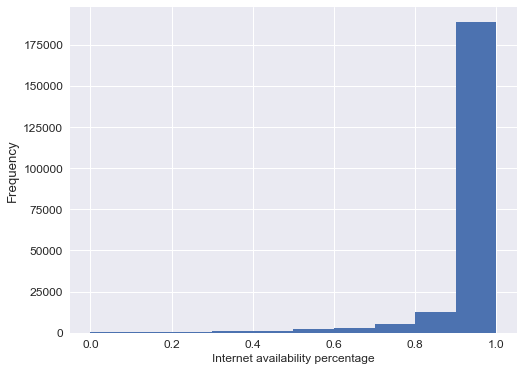

In [72]:
ax = data.int_avail_per.plot(kind='hist', figsize=(8, 6))
ax.set_xlabel('Internet availability percentage', fontsize=12)

In [73]:
data.int_avail_per.describe()

count    215566.000000
mean          0.958990
std           0.114091
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: int_avail_per, dtype: float64

In [74]:
full_coverage = (data.int_avail_per == 1).sum() / data.shape[0] * 100
print('block_group with full coverage', 100 - full_coverage)
print('block_group without full coverage', full_coverage)

block_group with full coverage 24.538192479333475
block_group without full coverage 75.46180752066653


# Correlation Analysis

Removing ethnicity & NA

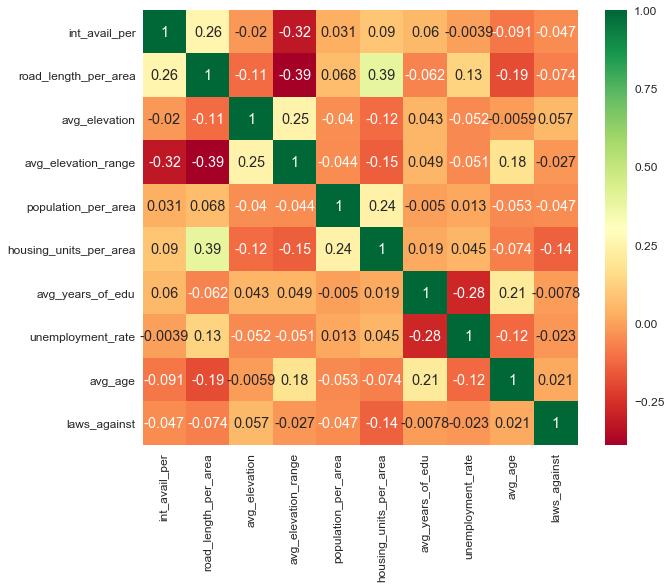

In [75]:
corr = existing_data.corr()

sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, ax=ax, cmap='RdYlGn', square=True, annot=True)

# Model

In [76]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

X = existing_data.drop(columns='int_avail_per')
y = existing_data['int_avail_per']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor()

model.fit(X_train, y_train)

print('Train score', model.score(X_train, y_train))
print('Test score', model.score(X_test, y_test))

Train score 0.8655965721172852
Test score 0.24550252735026157


In [ ]:
params = {
    'n_estimators': [200, 500, 1000],
    'min_samples_split': [5, 15, 20],
    'max_depth': [50, 100],
}

grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, verbose=True)
grid_search.fit(X_train, y_train)

print('Train score', grid_search.score(X_train, y_train))
print('Test score', grid_search.score(X_test, y_test))

In [ ]:
grid_search.best_params_

In [ ]:
coefficients = pd.DataFrame(list(zip(X.columns, grid_search.best_estimator_.feature_importances_))
                            , columns=['feature', 'coef'])
coefficients.sort_values('coef', ascending=False)